<a href="https://colab.research.google.com/github/mathewhall100/CHAMPS-molecular-properties/blob/master/CHAMPS(2)_XGBoost_and_Light_GBM_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHAMPS molecular properties challenge - training and prediction using XGBoost and Light GBM models

## Introduction

I have previously discussed the CHAMPS Molecular properties challenge and carried some EDA and feature construction from the competition datasets (https://www.kaggle.com/mathewhall/champs-molecular-properties-eda). Here we use the engineered data to train two popular gradient boosting machines, XBoost and LightGBM, and compare results. 

The clear winner, in this case LightGBM is taken and hyperparameters optimised using gridsearch.

The Dataset was also subdivided by coupling type to see whether training and prediction on subsets of more structurally similar data improved the error.

The lightGBM model trained with the whole dataset perfomed best and achieved a log mean absolute error (the competition metric) of -0.421. Test set predictions and submission to kagle gave a log MAE of -0.445 which placed 1697/2749 on the private leaderboard. 

## Library imports and notebook setup

In [0]:
# import all the other libraries we are going to need
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm_notebook as tqdm

In [0]:
# Manage warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [0]:
# show complete dataframes
pd.set_option('display.max_columns', None) # display all dataframe columns

## Get data and briefly examine it
For a more thorough EDA go to https://www.kaggle.com/mathewhall/champs-molecular-properties-eda

In [0]:
path = "../input/champs-scalar-coupling"
os.listdir(path)

['dipole_moments.csv',
 'potential_energy.csv',
 'magnetic_shielding_tensors.csv',
 'structures.csv',
 'scalar_coupling_contributions.csv',
 'structures',
 'sample_submission.csv',
 'mulliken_charges.csv',
 'test.csv',
 'train.csv']

We will only use three if the files provided:
1. train.csv - coded molecules names, index of coupling atoms, coupling type and constant
2. test.csv - same as test set but without coupling constants 
3. structures  - x,y cartesian co-ordinates of atom positions
note that the coupling constant (scalar_coupling_constant) is the label.

In [0]:
# Read train.csv and test.csv and load into dataframes
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train = pd.read_csv(path+'/train.csv', index_col='id', dtype=train_dtypes)
test = pd.read_csv(path+'/test.csv', index_col='id', dtype=train_dtypes)

# create'molecule_id' col from' molecule_name'
train['mol_index'] = train['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test['mol_index'] = test['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
train = train[['molecule_name', 'mol_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
test = test[['molecule_name', 'mol_index', 'atom_index_0', 'atom_index_1', 'type']]

print('Training set:')
display(train.head(5))
print('Test set:')
display(test.head(5))

Training set:


,molecule_name,mol_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,,
0,dsgdb9nsd_000001,1,1,0,1JHC,84.807602
1,dsgdb9nsd_000001,1,1,2,2JHH,-11.257000
2,dsgdb9nsd_000001,1,1,3,2JHH,-11.254800
3,dsgdb9nsd_000001,1,1,4,2JHH,-11.254300
4,dsgdb9nsd_000001,1,2,0,1JHC,84.807404


Test set:


,molecule_name,mol_index,atom_index_0,atom_index_1,type
id,,,,,
4658147,dsgdb9nsd_000004,4,2,0,2JHC
4658148,dsgdb9nsd_000004,4,2,1,1JHC
4658149,dsgdb9nsd_000004,4,2,3,3JHH
4658150,dsgdb9nsd_000004,4,3,0,1JHC
4658151,dsgdb9nsd_000004,4,3,1,2JHC


## Briefly check the datset 

For a more thourough EDA see https://www.kaggle.com/mathewhall/champs-molecular-properties-eda

In [0]:
# Examine the train and test datasets
train_data_rows = train.shape[0]
test_data_rows = test.shape[0]
train_unique_mols = train["molecule_name"].nunique()
test_unique_mols = test["molecule_name"].nunique()
train_test_split = round(train_unique_mols/(train_unique_mols+test_unique_mols), 2)
scc_types = train["type"].unique()

print(f'Train and test sets')
print(f'===================')
print(f'Number rows in training set: {train_data_rows}')
print(f'Number rows in test set: {test_data_rows}\n')
print(f'Unique molecules in training set: {train_unique_mols}')
print(f'Unique molecules in test set: {test_unique_mols}')
print(f'Total unique molecules: {train_unique_mols + test_unique_mols}')
print(f'Train/test split (by molecule): {train_test_split}:{1-train_test_split}\n')
print(f'Types of scaler coupling: {len(scc_types)} {scc_types}\n')

print(f'Check for missing values in train set: {"None" if train.isnull().sum().sum() == 0 else train.isnull().sum()}')
print(f'Check for missing values in test set: {"None" if test.isnull().sum().sum() == 0 else test.isnull().sum()}')

Train and test sets
Number rows in training set: 4658147
Number rows in test set: 2505542

Unique molecules in training set: 85003
Unique molecules in test set: 45772
Total unique molecules: 130775
Train/test split (by molecule): 0.65:0.35

Types of scaler coupling: 8 [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]
Categories (8, object): [1JHC, 2JHH, 1JHN, 2JHN, 2JHC, 3JHH, 3JHC, 3JHN]

Check for missing values in train set: None
Check for missing values in test set: None


In [0]:
# Read structures.csv and load into dataframe
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures = pd.read_csv(path+'/structures.csv', dtype=structures_dtypes)

print('Structures dataset:')
display(structures.head(5))

Structures dataset:


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [0]:
# examine the structures dataset
structures_data_rows = structures.shape[0]
structures_unique_mols = structures["molecule_name"].nunique()
atom_types = structures["atom"].unique()
print(f'STRUCTURES')
print(f'==========')
print(f'Number rows in structures set: {structures_data_rows}')
print(f'Unique molecules: {structures_unique_mols}')
print(f'Unique atoms: {len(atom_types)} {atom_types}\n')
print(f'Check \'structures\' contains same number of molecules as \'train\' and \'test\'  combined: {"True" if structures_unique_mols == train_unique_mols+test_unique_mols else "False"}')
print(f'Check for missing values: {"None" if structures.isnull().sum().sum() == 0 else structures.isnull().sum()}')

STRUCTURES
Number rows in structures set: 2358657
Unique molecules: 130775
Unique atoms: 5 [C, H, N, O, F]
Categories (5, object): [C, H, N, O, F]

Check 'structures' contains same number of molecules as 'train' and 'test'  combined: True
Check for missing values: None


## Utilities

In [0]:
# Scatterplot of actual vs predictions for each model
def plot_preds(data, model_name):
    plt.figure(figsize=(6,6))
    scatterplt = sns.scatterplot(x=data["scalar_coupling_constants"], y=data['preds'])
    scatterplt.set(xlabel='Scalar_coupling_constants (SCC)', ylabel='SCC predicted')
    plt.title(f'Actual vs predicted coupling constants for {model_name}', pad=20)
    plt.show()

In [0]:
# check dataframe mem usage
print('Shape: ', train.shape)
print('Total Mem usage: ', train.memory_usage().sum())
train.memory_usage()

Shape:  (4658147, 6)
Total Mem usage:  110439229


Index                       37265176
molecule_name               21934052
mol_index                   18632588
atom_index_0                 4658147
atom_index_1                 4658147
type                         4658531
scalar_coupling_constant    18632588
dtype: int64

In [0]:
# Minimise dataframe mem usage 
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [0]:
# Read in a file and optimise its memory usage
def import_data(file):
    df = pd.read_csv(file, parse_dates=True, keep_dat_col=True)
    df = reduce_mem_usage(df)
    return df

## Construct Features

See https://www.kaggle.com/mathewhall/champs-molecular-properties-eda for a more detailed description of feature construction and analysis.

Thank you to the following kernals and datasets for inspiration, data and code examples: https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures, https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481, https://www.kaggle.com/aekoch95/bonds-from-structure-data


In [0]:
# Calculate chemical bonding of each atom (number bonds, index atom(s) bonded to and bond length(s))
# Returns datafarme of bonding data

def add_bonds(structures):
    
    atom_rad= {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71}          
    structures['rad'] = [atom_rad[x] for x in structures['atom'].values]
    
    bonding_margin= 0.05
    index_atom = structures['atom_index'].values
    p_comp = p = structures[['x','y','z']].values
    m_comp = m = structures['molecule_name'].values
    r_comp = r = structures['rad'].values + bonding_margin

    src_row = np.arange(len(structures))
    max_atoms = 29
    bonds = np.zeros((len(structures)+1, max_atoms), dtype=np.int8)
    bond_dists = np.zeros((len(structures)+1, max_atoms), dtype=np.float32)
    
    for i in tqdm(range(max_atoms-1), desc="Calculating bonds: "):
        p_comp = np.roll(p_comp, -1, axis=0)
        m_comp = np.roll(m_comp, -1, axis=0)
        r_comp = np.roll(r_comp, -1, axis=0)

        mask = np.where(m == m_comp, 1, 0)
        dists = np.linalg.norm(p - p_comp, axis=1) * mask
    
        r_bond = r + r_comp
        bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)

        targ_row = src_row + i +1
        targ_row = np.where(np.logical_or(targ_row > len(structures), mask==0), len(structures), targ_row)

        src_atom = index_atom
        targ_atom = index_atom + i + 1
        targ_atom = np.where(np.logical_or(targ_atom > max_atoms-1, mask==0), max_atoms-1, targ_atom)

        bonds[(src_row, targ_atom)] = bond
        bonds[(targ_row, src_atom)] = bond
        bond_dists[(src_row, targ_atom)] = dists
        bond_dists[(targ_row, src_atom)] = dists

    bonds = np.delete(bonds, axis=0, obj=-1)
    bonds = np.delete(bonds, axis=1, obj=-1)
    bond_dists = np.delete(bond_dists, axis=0, obj=-1)
    bond_dists = np.delete(bond_dists, axis=1, obj=-1)
    
    print('Processing bond calculations...')
    bonds_to = [[i for i, x in enumerate(row) if x] for row in bonds]
    bond_lengths = [[dist for i, dist in enumerate(row) if i in bonds_to[j]] for j,row in enumerate(bond_dists)]
    n_bonds = [len(x) for x in bonds_to]
   
    print('Creating bonds dataframe...')
    bonds_df = pd.DataFrame({'num_bonds':n_bonds, 'bond_lengths':bond_lengths})
    bonds_df[['bond_len1', 'bond_len2', 'bond_len3', 'bond_len4']] = pd.DataFrame(bonds_df.bond_lengths.values.tolist())
    bonds_df.fillna({'bond_len1':0, 'bond_len2':0, 'bond_len3':0, 'bond_len4':0}, inplace=True) # replace NaN's with 0's
    bonds_df.drop('bond_lengths', axis=1, inplace=True)
    
    structures.drop('rad', axis=1, inplace=True) #needed only for bonding calculations
    
    print(f'Check \'bonds dataframe\' contains same number of rows as \'structures\': {"True" if structures_data_rows == bonds_df.shape[0] else "False"}')
    return bonds_df

In [0]:
# Add bonding lengths to structures dataset 

print('Adding bonding features \'num_bonds\' & \'bond_len(1-4)\' to \'structures\' ')
bonds_df = add_bonds(structures)
structures = structures.join(bonds_df)
structures.head()

Adding bonding features 'num_bonds' & 'bond_len(1-4)' to 'structures' 



Processing bond calculations...
Creating bonds dataframe...
Check 'bonds dataframe' contains same number of rows as 'structures': True


,molecule_name,atom_index,atom,x,y,z,num_bonds,bond_len1,bond_len2,bond_len3,bond_len4
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,1,1.091953,0.000000,0.000000,0.000000
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000


In [0]:
# Map atom structures data into train and test sets

def map_structure_data(df, atom_idx):
    df = pd.merge(df, structures, how='left',
                 left_on = ['molecule_name', f'atom_index_{atom_idx}'],
                 right_on = ['molecule_name', 'atom_index'])
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x':f'x_{atom_idx}',
                            'y':f'y_{atom_idx}',
                            'z':f'z_{atom_idx}',
                           })
    return df

In [0]:
# Add structure data to train and test sets
# Drop redundant bond features and rename some others for clarity

def add_structures(df):
    df = map_structure_data(df, 0)
    df = map_structure_data(df, 1)
    df = df.drop(['num_bonds_x', 'bond_len1_x', 'bond_len2_x', 'bond_len3_x', 'bond_len4_x'], axis=1)
    df = df.rename(columns={'num_bonds_y':'num_bonds_atom_1',
                            'bond_len1_y':'bond_len1',
                            'bond_len2_y':'bond_len2',
                            'bond_len3_y':'bond_len3',
                            'bond_len4_y':'bond_len4'
                           })
    return df

print('Merging \'structures\' with \'train\' and \'test\'')
train = add_structures(train)
test = add_structures(test)

train.head()

Merging 'structures' with 'train' and 'test'


,molecule_name,mol_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4
0,dsgdb9nsd_000001,1,1,0,1JHC,84.807602,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948
1,dsgdb9nsd_000001,1,1,2,2JHH,-11.257000,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1,1.091952,0.000000,0.000000,0.000000
2,dsgdb9nsd_000001,1,1,3,2JHH,-11.254800,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1,1.091946,0.000000,0.000000,0.000000
3,dsgdb9nsd_000001,1,1,4,2JHH,-11.254300,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1,1.091948,0.000000,0.000000,0.000000
4,dsgdb9nsd_000001,1,2,0,1JHC,84.807404,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,4,1.091953,1.091952,1.091946,1.091948


In [0]:
# Calculate distances between coupled atoms and to center molecule

def calc_distances(df):
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['distance_vector'] = np.linalg.norm(p_0 - p_1, axis=1)
    
    df['cent_x'] = ((df['x_0'] - df['x_1'])) * np.float32(0.5)
    df['cent_y'] = ((df['y_0'] - df['y_1'])) * np.float32(0.5)
    df['cent_z'] = ((df['z_0'] - df['z_1'])) * np.float32(0.5)
    df['distance_center'] = ((
        (df['cent_x'] - df['x_1']) ** np.float32(2) + 
        (df['cent_y'] - df['y_1']) ** np.float32(2) +
        (df['cent_z'] - df['z_1']) ** np.float32(2)
    ) ** np.float32(0.5))


In [0]:
# Add distance features to datasets
calc_distances(train)
calc_distances(test)

# Drop original position data as only needed for calculating distances
train.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'],axis=1, inplace=True)
test.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'],axis=1, inplace=True)

train.head()

,molecule_name,mol_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,atom_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center
0,dsgdb9nsd_000001,1,1,0,1JHC,84.807602,H,C,4,1.091953,1.091952,1.091946,1.091948,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883
1,dsgdb9nsd_000001,1,1,2,2JHH,-11.257000,H,H,1,1.091952,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930
2,dsgdb9nsd_000001,1,1,3,2JHH,-11.254800,H,H,1,1.091946,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176
3,dsgdb9nsd_000001,1,1,4,2JHH,-11.254300,H,H,1,1.091948,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223
4,dsgdb9nsd_000001,1,2,0,1JHC,84.807404,H,C,4,1.091953,1.091952,1.091946,1.091948,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220


In [0]:
# Load additional file with 2j cosine and 3j dihedral angles already computed for each coupling
# Data file downloaded from https://www.kaggle.com/soerendip/angle-and-dihedral-for-the-champs-structures

angles = pd.read_csv("../input/angle-and-dihedral-for-the-champs-structures/angles.csv")
angles.head()

,molecule_name,atom_index_0,atom_index_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,NaN,1,NaN,NaN
1,dsgdb9nsd_000001,1,2,C,2,-0.33329,NaN
2,dsgdb9nsd_000001,1,3,C,2,-0.33333,NaN
3,dsgdb9nsd_000001,1,4,C,2,-0.33335,NaN
4,dsgdb9nsd_000001,2,0,NaN,1,NaN,NaN


In [0]:
# Remove NaNs from angles df
angles_unique_mols = angles['molecule_name'].nunique()
print(f'Check \'angles\' contains same number of molecules as \'train\' and \'test\'  combined: {"True" if angles_unique_mols == train_unique_mols+test_unique_mols else "False"}')
print(f'Check for missing values: {"None" if angles.isnull().sum().sum() == 0 else angles.isnull().sum()}')

if angles.isnull().sum().sum() != 0: 
    print('...')
    angles.fillna({'cosinus':0, 'dihedral':0, 'shortest_path_atoms':'H'}, inplace=True)
    print('NaNs removed from shortest_path_atoms, cosinus and dihedral columns')
    
angles.head()

Check 'angles' contains same number of molecules as 'train' and 'test'  combined: True
Check for missing values: molecule_name                  0
atom_index_0                   0
atom_index_1                   0
shortest_path_atoms      1157583
shortest_path_n_bonds          0
cosinus                  4645080
dihedral                 3676340
dtype: int64
...
NaNs removed from shortest_path_atoms, cosinus and dihedral columns


,molecule_name,atom_index_0,atom_index_1,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,H,1,0.00000,0.0
1,dsgdb9nsd_000001,1,2,C,2,-0.33329,0.0
2,dsgdb9nsd_000001,1,3,C,2,-0.33333,0.0
3,dsgdb9nsd_000001,1,4,C,2,-0.33335,0.0
4,dsgdb9nsd_000001,2,0,H,1,0.00000,0.0


In [0]:
# Merge angles df with train and test dfs

def map_angle_info(df):
    df = pd.merge(df, angles, how='left',
                 left_on = ['molecule_name', 'atom_index_0', 'atom_index_1'],
                 right_on = ['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df
                            
train = map_angle_info(train)                         
test = map_angle_info(test)

# Remove the 148 higher order couplings from the train and test sets as invalid data
train = train.loc[train.shortest_path_n_bonds<4,:]
# test = test.loc[test.shortest_path_n_bonds<4, :] If we remove these from the test set then we must aslo remove them from the submission.csv file. 

train.head(5)

,molecule_name,mol_index,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,atom_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,1,0,1JHC,84.807602,H,C,4,1.091953,1.091952,1.091946,1.091948,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883,H,1,0.00000,0.0
1,dsgdb9nsd_000001,1,1,2,2JHH,-11.257000,H,H,1,1.091952,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930,C,2,-0.33329,0.0
2,dsgdb9nsd_000001,1,1,3,2JHH,-11.254800,H,H,1,1.091946,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176,C,2,-0.33333,0.0
3,dsgdb9nsd_000001,1,1,4,2JHH,-11.254300,H,H,1,1.091948,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223,C,2,-0.33335,0.0
4,dsgdb9nsd_000001,1,2,0,1JHC,84.807404,H,C,4,1.091953,1.091952,1.091946,1.091948,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220,H,1,0.00000,0.0


## Preprocessing

At this stage the train dataset has a number of catagorical features which need encoding:
* 'Atom_0'
* 'Atom_1'
* 'type'
* 'shortest_path_atoms'

As a general rule, tree based algorithms, which include gradient boosting models, perform poorly on one hot encoded catagorical data. For these models we need to nominal encode the data using scikit learns LabelEncoder module.

In [0]:
# Label encode

for f in ['atom_0', 'atom_1', 'shortest_path_atoms', 'type']:
    encoder = LabelEncoder() 
    encoder.fit(list(train[f].values) + list(test[f].values))
    train[f] = encoder.transform(list(train[f].values))
    test[f] = encoder.transform(list(test[f].values))

# create a encoder mapping dict for later unencoding of the 'type' column
encoder_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(encoder_mapping)

{'1JHC': 0, '1JHN': 1, '2JHC': 2, '2JHH': 3, '2JHN': 4, '3JHC': 5, '3JHH': 6, '3JHN': 7}


In [0]:
# Drop redundant features
train.drop(['atom_index_0', 'atom_index_1'],axis=1, inplace=True)
test.drop(['atom_index_0', 'atom_index_1'],axis=1, inplace=True)

In [0]:
# Convert remaining Nans to zeros (better for GBM's)
def fill_zeros(df):
    df = df.fillna(0)

fill_zeros(train)
fill_zeros(test)
print(" NaN's replaced with 0s for train & test files")

 NaN's replaced with 0s for train & test files


In [0]:
# Remove any columns with only a single unique value
def remove_single_val_cols(df):
    for col in df.columns:
        if len(df[col].unique()) == 1:
            df.drop(col,inplace=True,axis=1)
            
remove_single_val_cols(train)
remove_single_val_cols(test)

In [0]:
# Minimise dataframe sizes
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 324.29 Mb (49.3% reduction)
Mem. usage decreased to 164.87 Mb (50.7% reduction)


## Review train and test files

In [0]:
print(f'Train : {train.shape}')
display(train.head())
print(f'Test: {train.shape}')
display(test.head())

Train : (4658051, 22)


,molecule_name,mol_index,type,scalar_coupling_constant,atom_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,84.807602,0,4,1.091797,1.091797,1.091797,1.091797,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883,14,1,0.000000,0.0
1,dsgdb9nsd_000001,1,3,-11.257000,1,1,1.091797,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930,0,2,-0.333252,0.0
2,dsgdb9nsd_000001,1,3,-11.254800,1,1,1.091797,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176,0,2,-0.333252,0.0
3,dsgdb9nsd_000001,1,3,-11.254300,1,1,1.091797,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223,0,2,-0.333252,0.0
4,dsgdb9nsd_000001,1,0,84.807404,0,4,1.091797,1.091797,1.091797,1.091797,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220,14,1,0.000000,0.0


Test: (4658051, 22)


,molecule_name,mol_index,type,atom_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000004,4,2,0,2,1.199219,1.0625,0.0,0.0,5.112926,0.0,0.0,2.261178,-1.130589,0.0,0.0,1.998335,0,2,-1.0,0.0
1,dsgdb9nsd_000004,4,0,0,2,1.199219,1.0625,0.0,0.0,1.128054,0.0,0.0,1.062099,-0.531050,0.0,0.0,1.002343,14,1,0.0,0.0
2,dsgdb9nsd_000004,4,6,1,1,1.062500,0.0000,0.0,0.0,11.044171,0.0,0.0,3.323277,-1.661639,0.0,0.0,3.470471,1,3,0.0,0.0
3,dsgdb9nsd_000004,4,0,0,2,1.199219,1.0625,0.0,0.0,1.128054,0.0,0.0,1.062099,0.531050,0.0,0.0,1.002343,14,1,0.0,0.0
4,dsgdb9nsd_000004,4,2,0,2,1.199219,1.0625,0.0,0.0,5.112926,0.0,0.0,2.261178,1.130589,0.0,0.0,1.998335,0,2,-1.0,0.0


## Prepare data for GBM models

In [0]:
# Data for training
cols =['mol_index','type','atom_1', 'num_bonds_atom_1', 'bond_len1', 'bond_len2', 'bond_len3', 
       'bond_len4','dist_x', 'dist_y', 'dist_z', 'distance_vector', 'cent_x', 'cent_y', 'cent_z', 
       'distance_center','shortest_path_atoms', 'shortest_path_n_bonds', 'cosinus', 'dihedral']

In [0]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split

def split_train_data(df):
    X_train, X_val, Y_train, Y_val = train_test_split(df[cols].values, df.loc[:, 'scalar_coupling_constant'].values, test_size=0.2, random_state=142)
    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = split_train_data(train)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((3726440, 20), (931611, 20), (3726440,), (931611,))

In [0]:
# Create a test set
X_test = test[cols].values

## XGBoost


In [0]:
import xgboost as xgb
from xgboost import XGBRegressor

In [0]:
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

In [0]:
# Get model object and fit
# We train for 50 iterations (trees) with most parameters set to default. 
# Training for more iterations did not significantly improve the result

model_xgb = XGBRegressor(**params_xgb, n_estimators=50, learning_rate=0.1, booster='gbtree', seed=142, n_jobs=4)
model_xgb.fit(X_train, Y_train, early_stopping_rounds=5, eval_set=[(X_train, Y_train)], eval_metric='mae')

[0]	validation_0-mae:16.5838
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:15.0992
[2]	validation_0-mae:13.7448
[3]	validation_0-mae:12.5786
[4]	validation_0-mae:11.5329
[5]	validation_0-mae:10.5941
[6]	validation_0-mae:9.72995
[7]	validation_0-mae:8.95236
[8]	validation_0-mae:8.26958
[9]	validation_0-mae:7.64693
[10]	validation_0-mae:7.09531
[11]	validation_0-mae:6.56592
[12]	validation_0-mae:6.09882
[13]	validation_0-mae:5.68458
[14]	validation_0-mae:5.29406
[15]	validation_0-mae:4.96775
[16]	validation_0-mae:4.66299
[17]	validation_0-mae:4.38616
[18]	validation_0-mae:4.14095
[19]	validation_0-mae:3.91503
[20]	validation_0-mae:3.72809
[21]	validation_0-mae:3.55725
[22]	validation_0-mae:3.40273
[23]	validation_0-mae:3.26792
[24]	validation_0-mae:3.14843
[25]	validation_0-mae:3.04324
[26]	validation_0-mae:2.96243
[27]	validation_0-mae:2.88948
[28]	validation_0-mae:2.82351
[29]	validation_0-mae:2.76775
[30]	validation_0-mae:2.71782
[31]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eval_metric='mae',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=4, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=142, silent=None,
             subsample=0.8, verbosity=1)

In [0]:
print("Results: {}".format(model_xgb.evals_result()))
print("Best Iteration: {}".format(model_xgb.get_booster().best_iteration))
print("Best Iteration: {}".format(model_xgb.get_booster().best_score))
print("Feature importances: {}".format(model_xgb.feature_importances_))

Results: {'validation_0': {'mae': [16.583771, 15.099237, 13.744792, 12.578604, 11.532896, 10.594051, 9.729951, 8.952362, 8.26958, 7.646933, 7.095306, 6.565923, 6.098825, 5.684577, 5.294059, 4.967754, 4.662986, 4.386157, 4.140945, 3.915033, 3.728087, 3.557254, 3.402734, 3.267924, 3.148425, 3.043242, 2.962428, 2.889477, 2.82351, 2.76775, 2.717825, 2.671001, 2.629484, 2.600083, 2.571067, 2.549139, 2.526502, 2.505454, 2.491348, 2.471695, 2.45894, 2.446757, 2.432832, 2.420822, 2.411087, 2.395733, 2.387349, 2.380424, 2.36873, 2.359555]}}
Best Iteration: 49
Best Iteration: 2.359555
Feature importances: [1.8269435e-05 2.2067089e-01 3.6567517e-02 4.2412737e-03 1.5346581e-03
 1.2461800e-03 2.0222031e-03 1.4684597e-02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5301306e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1324298e-03 7.0103663e-01 7.5697183e-04 7.8709662e-04]


In [0]:
# make predictions on the validation set and give result as log of MAE (the competition metric)
y_pred_xgb = model_xgb.predict(X_val)
score_xgb = np.log(mean_absolute_error(Y_val, y_pred_xgb))
print(f'XGBoost score (log MAE): {score_xgb}')

XGBoost score (log MAE): 0.8596256971359253


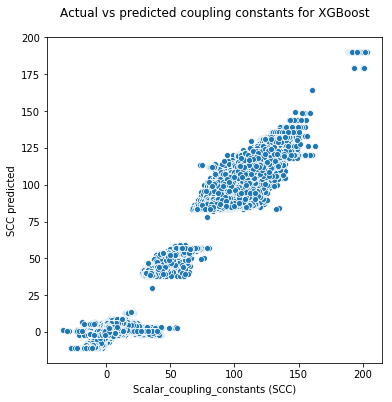

In [0]:
# plot predicted vs actual for validation set
plot_data_xgb = pd.DataFrame(data=Y_val, columns=['scalar_coupling_constants'])
plot_data_xgb.index.name = 'id'
plot_data_xgb['preds'] = y_pred_xgb

plot_preds(plot_data_xgb, "XGBoost" )

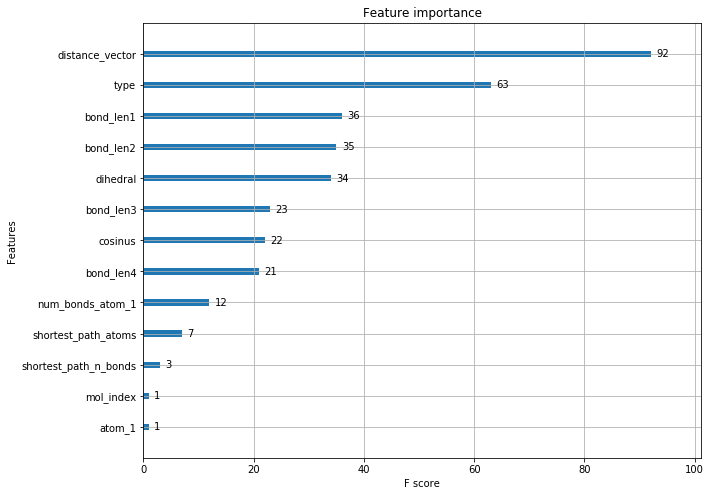

In [0]:
# plot feature importances
model_xgb.get_booster().feature_names = cols
fig, ax = plt.subplots(figsize=(10,8))
ax = xgb.plot_importance(model_xgb.get_booster(), ax=ax)

Interestingly, the most importnat features were distance vector, coupling type, bond lengths and angles which are exactly the factors that influence the magnitude of coupling constants in the wild. So we are likelt on the right track with our feature constuction. 

## Light GBM
Light LGBM horizontal tree based gradient boosting.  

In [0]:
import lightgbm as lgb

In [0]:
# Get model object and fit
# We set the learning rate to 0.2 and number of leaves to 1000 but otherwise leave the other parameters to default
# We show training for 1200 rounds but further improvements in MAE were gained with trainig up to around 4000 rounds. 

params_lgb = {'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.2,
            'num_leaves': 1000, 
            'nthread': 4, 
            'device': 'cpu'}

In [0]:
# get model object and fit
lgb_train = lgb.Dataset(X_train,Y_train)
lgb_val = lgb.Dataset(X_val, Y_val)
evals_result = {}

num_boost_round = 1200
early_stopping_rounds = 200

model_lgb = lgb.train(params_lgb,
                 lgb_train,
                 num_boost_round=num_boost_round,
                 valid_sets=[lgb_train, lgb_val],
                 early_stopping_rounds=early_stopping_rounds,
                 evals_result=evals_result,
                 verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.07604	valid_1's l1: 1.1438
[200]	training's l1: 0.969984	valid_1's l1: 1.08103
[300]	training's l1: 0.89496	valid_1's l1: 1.04187
[400]	training's l1: 0.836625	valid_1's l1: 1.0142
[500]	training's l1: 0.788833	valid_1's l1: 0.994859
[600]	training's l1: 0.747704	valid_1's l1: 0.97865
[700]	training's l1: 0.7112	valid_1's l1: 0.966721
[800]	training's l1: 0.678677	valid_1's l1: 0.955998
[900]	training's l1: 0.648555	valid_1's l1: 0.947135
[1000]	training's l1: 0.622527	valid_1's l1: 0.940029
[1100]	training's l1: 0.598679	valid_1's l1: 0.933778
[1200]	training's l1: 0.576333	valid_1's l1: 0.927854
Did not meet early stopping. Best iteration is:
[1200]	training's l1: 0.576333	valid_1's l1: 0.927854


In [0]:
# print(model_lgb.eval_result())
print(f'Best iteration: {model_lgb.best_iteration}')
print(f'Best Score: {model_lgb.best_score}')

Best iteration: 1200
Best Score: defaultdict(<class 'dict'>, {'training': {'l1': 0.5763331349815004}, 'valid_1': {'l1': 0.9278543612378087}})


In [0]:
# make predictions on the validation set and give result as log of MAE (the competition metric)
y_pred_lgb=model_lgb.predict(X_val)
score_lgb = np.log(mean_absolute_error(Y_val, y_pred_lgb))
print(f'Light GBM score (log MAE): {score_lgb}')

Light GBM score (log MAE): -0.07488049683336184


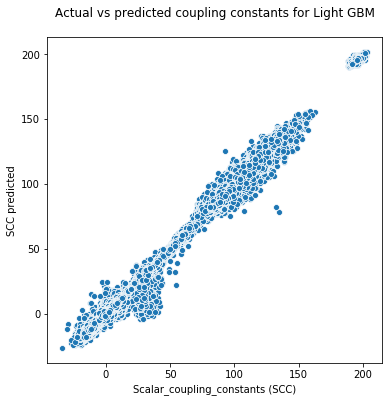

In [0]:
# Plot predicted vs actual coupling constants for validation set
import matplotlib.pyplot as plt

plot_data_lgb = pd.DataFrame(data=Y_val, columns=['scalar_coupling_constants'])
plot_data_lgb.index.name = 'id'
plot_data_lgb['preds'] = y_pred_lgb

plot_preds(plot_data_lgb, "Light GBM")

Feature importances Light GBM model


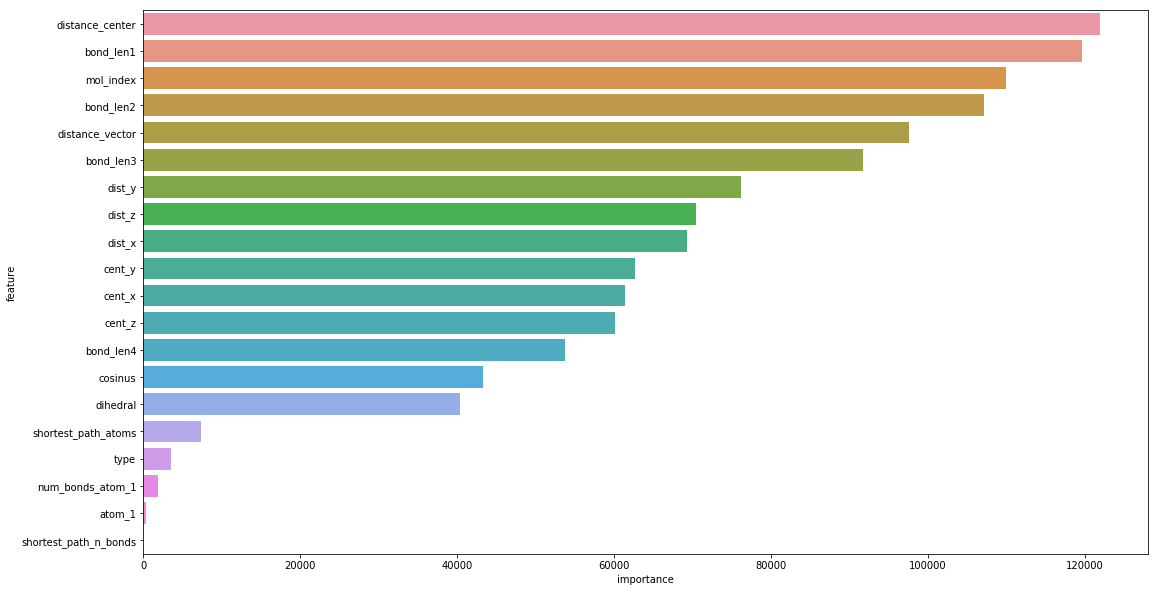

In [0]:
# Plot feature importances
import matplotlib.pyplot as plt

cols_ = (list(train[cols].columns))
df_importance = pd.DataFrame({'feature': cols_, 'importance': model_lgb.feature_importance()})
print('Feature importances Light GBM model')

plt = plt.figure(figsize=(18,10))
sns.barplot(x='importance', y='feature', data=df_importance.sort_values('importance', ascending=False))
plt.show()


Similar to the XBoost model, LGBM feature importances highlight bond lengths and vector distances as most important and atoms types least important. 

## LGBM Regressor
Scikit learn's implementation of Light GBM (should give same results as Light GBM - but lets check!)

In [0]:
from lightgbm import LGBMRegressor

In [0]:
# Get model object and fit
model_lgbreg = LGBMRegressor(**params_lgb, n_estimators=1200, n_jobs=-1)
model_lgbreg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], eval_metric='mae', verbose=100, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.07604	valid_1's l1: 1.1438
[200]	training's l1: 0.969984	valid_1's l1: 1.08103
[300]	training's l1: 0.89496	valid_1's l1: 1.04187
[400]	training's l1: 0.836625	valid_1's l1: 1.0142
[500]	training's l1: 0.788833	valid_1's l1: 0.994859
[600]	training's l1: 0.747704	valid_1's l1: 0.97865
[700]	training's l1: 0.7112	valid_1's l1: 0.966721
[800]	training's l1: 0.678677	valid_1's l1: 0.955998
[900]	training's l1: 0.648555	valid_1's l1: 0.947135
[1000]	training's l1: 0.622527	valid_1's l1: 0.940029
[1100]	training's l1: 0.598679	valid_1's l1: 0.933778
[1200]	training's l1: 0.576333	valid_1's l1: 0.927854
Did not meet early stopping. Best iteration is:
[1200]	training's l1: 0.576333	valid_1's l1: 0.927854


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              device='cpu', importance_type='split', learning_rate=0.2,
              max_depth=-1, metric='mae', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=1200,
              n_jobs=-1, nthread=4, num_leaves=1000, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# make predictions on the validation set and give result as log of MAE (the competition metric)
y_pred_lgbreg = model_lgbreg.predict(X_val)
score_lgbreg = np.log(mean_absolute_error(Y_val, y_pred_lgbreg))
print(f'LGBRegression score (log MAE): {score_lgbreg}')

LGBRegression score (log MAE): -0.07488049683336567


## Best Model : Light GBM or LGBMRegressor
LightGBM and LGBMRegressor gave same scores with default set of parameters. Lets use LBMRegressor as our best model going forward.

Examine the feature importances and predictions from the best model in a bit more detail

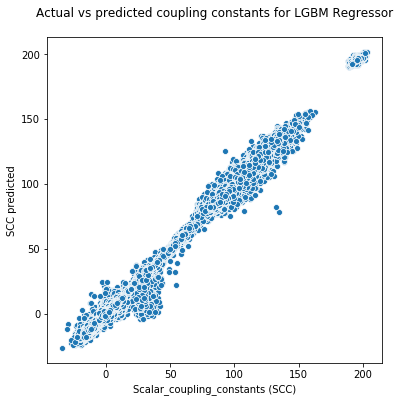

In [0]:
# plot predicted vs actual for whole validation set
import matplotlib.pyplot as plt
plot_data_lgbreg = pd.DataFrame(data=Y_val, columns=['scalar_coupling_constants'])
plot_data_lgbreg.index.name = 'id'
plot_data_lgbreg['preds'] = y_pred_lgbreg

plot_preds(plot_data_lgbreg, "LGBM Regressor")

Feature importances Light GBM model


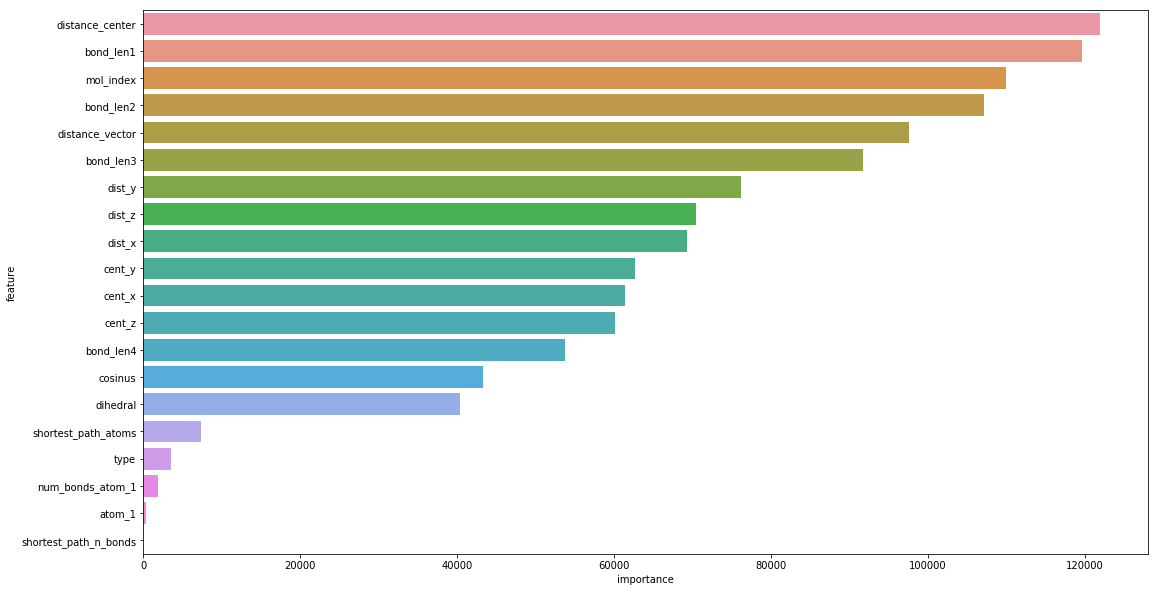

In [0]:
# Plot feature importances
import matplotlib.pyplot as plt

cols = (list(train[cols].columns))
df_importance = pd.DataFrame({'feature': cols, 'importance': model_lgbreg.feature_importances_})
print('Feature importances Light GBM model')

plt = plt.figure(figsize=(18,10))
sns.barplot(x='importance', y='feature', data=df_importance.sort_values('importance', ascending=False))
plt.show()

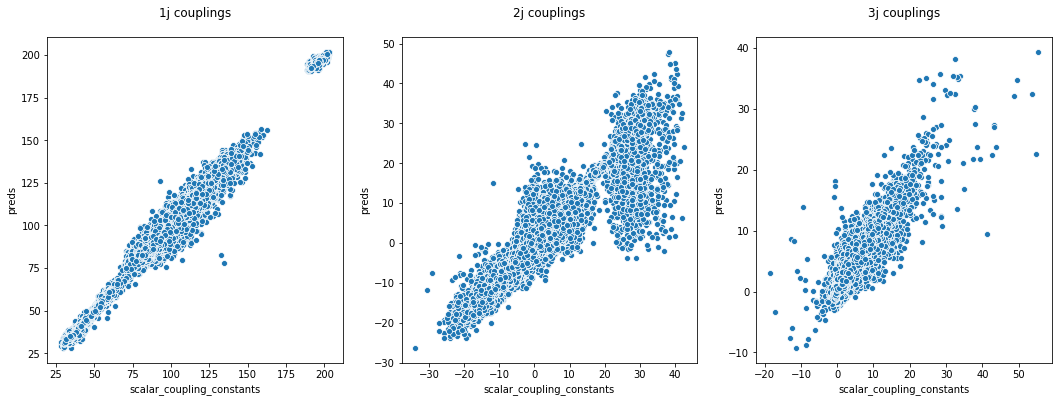

In [0]:
# plot predicted vs actual coupling constants for each type of j coupling, 1j, 2j and 3j
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,6))

def plot_preds_by_j(data, j):
    plt.subplot(1,3,j)
    plot_data = data[X_val[:,17] == j]
    sns.scatterplot(x=plot_data["scalar_coupling_constants"], y=data['preds'])
    plt.title(f'{j}j couplings', pad='20')

for x in range(3): plot_preds_by_j(plot_data_lgbreg, x+1)
fig.show()

## Optimise best model (LightGBM) parameters using GridSearch

In [0]:
# GridSearch
# Initial experimentation suggested that num_leaves, subsamples and col_sample_by_tree whad the greatest infuence on results and so we tune these with gridsearch. 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=3, random_state=142)
X_train_src, X_val_src, Y_train_src, Y_val_src = train_test_split(X_val, Y_val, train_size=0.07, test_size=0.03, random_state=142)
print(f'{X_train_src.shape}, {X_val_src.shape}, {Y_train_src.shape}, {Y_val_src.shape}')

params_grid = {#'n_estimators':[200],
               'max_depth':  [-1],
               'num_leaves': [512, 1024, 2048, 4096],
               'subsample': [0.2, 0.4, 0.6, 0.8],
               'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
                }
print(f'Start GridSearch')
print(f'Sample size: {len(X_val_src)}')
print(f'Search parameters:  {params_grid}')
print('...')

est_lgb = LGBMRegressor(boosting='gbdt', n_jobs = -1, random_state=142)
gs = GridSearchCV(est_lgb, params_grid, scoring='neg_mean_absolute_error', verbose=True, n_jobs=-1, cv=kf)
gs_results = gs.fit(X_train_src, Y_train_src)

print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))

# Predict (after fitting GridSearch is an estimator with best parameters)
y_pred = gs.predict(X_val_src)

# Score
score = mean_absolute_error(Y_val_src, y_pred)
print("MAE SCORE ON TEST DATA: {}".format(score))

(65212, 20), (27949, 20), (65212,), (27949,)
Start GridSearch
Sample size: 27949
Search parameters:  {'max_depth': [-1], 'num_leaves': [512, 1024, 2048, 4096], 'subsample': [0.2, 0.4, 0.6, 0.8], 'colsample_bytree': [0.6, 0.7, 0.8, 1.0]}
...
Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 23.7min finished


BEST PARAMETERS: {'colsample_bytree': 0.8, 'max_depth': -1, 'num_leaves': 2048, 'subsample': 0.2}
BEST CV SCORE: -1.5268705558080045
MAE SCORE ON TEST DATA: 1.468372710443751


## Retrain and predict
Retrain our LightGBM best model on the whole dataset using the optimised parameters from GridSearch above 

Also increase the number of iterations to 2000 or until early stopping.

In [0]:
# Optimised parameters
params_lgb_opt = {'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.2,
            'num_leaves': 4096,
            'subsample': 0.2,
            'colsample_bytree': 0.8,
            'nthread': 4, 
            'device': 'cpu'}

In [0]:
# Get model object and fit
model_lgbreg = LGBMRegressor(**params_lgb_opt, n_estimators=2000, n_jobs=-1)
model_lgbreg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], eval_metric='mae', verbose=200, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 0.686447	valid_1's l1: 0.965036
[400]	training's l1: 0.51014	valid_1's l1: 0.918781
[600]	training's l1: 0.40361	valid_1's l1: 0.898707
[800]	training's l1: 0.328932	valid_1's l1: 0.888677
[1000]	training's l1: 0.273027	valid_1's l1: 0.881905
[1200]	training's l1: 0.227641	valid_1's l1: 0.877139
[1400]	training's l1: 0.19198	valid_1's l1: 0.873829
[1600]	training's l1: 0.163145	valid_1's l1: 0.871436
[1800]	training's l1: 0.139425	valid_1's l1: 0.869701
[2000]	training's l1: 0.119732	valid_1's l1: 0.868435
Did not meet early stopping. Best iteration is:
[2000]	training's l1: 0.119732	valid_1's l1: 0.868435


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
              device='cpu', importance_type='split', learning_rate=0.2,
              max_depth=-1, metric='mae', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
              n_jobs=-1, nthread=4, num_leaves=4096, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.2, subsample_for_bin=200000, subsample_freq=0)

After 1200 iterations we have a validation loss (MAE) of 0.864546 compared to 0.927854 for the LGBM model with default parameters so it look like the model is performing much better with our hyperparameter optimisation. Thanks GridSearch!

In [0]:
# make predictions on the validation set and give result as log of MAE (the competition metric)
y_pred_lgbreg = model_lgbreg.predict(X_val)
score_lgbreg = np.log(mean_absolute_error(Y_val, y_pred_lgbreg))
print(f'LGBRegression score (log MAE): {score_lgbreg}')

LGBRegression score (log MAE): -0.14106292354532957


## Split the dataset by coupling type and train/predict on each subset individually.

EDA showed that for some features there was a clear grouping of the data characteristics by coupling type. So lets try splitting the  dataset into subsets by coupling type and train/predict on each subset individually then recombine to give an overall score.

In [0]:
%%time
from sklearn.model_selection import train_test_split

types = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', "3JHN"]
train_t = [0] * 8
val_t = [0] * 8
for i, t in enumerate(types):
    t_map = encoder_mapping[t]
    train_t[i], val_t[i] = train_test_split(train[train.type== t_map], train_size=0.75, shuffle=False, random_state=42)

def get_split_info(train, val):
    r = round(len(train)/(len(train)+len(val)), 2)
    t_bonds = len(train)+len(val)
    return [r, len(train), train["molecule_name"].nunique(), 1-r, len(val), val["molecule_name"].nunique()]
          
df_data = [get_split_info(train_t[0], val_t[0]), get_split_info(train_t[1], val_t[1]), get_split_info(train_t[2], val_t[2]), get_split_info(train_t[3], val_t[3]), 
           get_split_info(train_t[4], val_t[4]), get_split_info(train_t[5], val_t[5]), get_split_info(train_t[6], val_t[6]), get_split_info(train_t[7], val_t[7])]
df_cols = ['train split', 'train: bonds', 'train: unique mols', 'val split', 'val: bonds', 'val: unique mols']
df_idx = types
df = pd.DataFrame(df_data, columns=df_cols, index=df_idx)
df

train.head()


CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.07 s


,molecule_name,mol_index,type,scalar_coupling_constant,atom_1,num_bonds_atom_1,bond_len1,bond_len2,bond_len3,bond_len4,dist_x,dist_y,dist_z,distance_vector,cent_x,cent_y,cent_z,distance_center,shortest_path_atoms,shortest_path_n_bonds,cosinus,dihedral
0,dsgdb9nsd_000001,1,0,84.807602,0,4,1.091797,1.091797,1.091797,1.091797,0.000220,1.192104,0.000036,1.091953,0.007424,-0.545918,-0.003012,1.631883,14,1,0.000000,0.0
1,dsgdb9nsd_000001,1,3,-11.257000,1,1,1.091797,0.000000,0.000000,0.000000,1.019253,2.160260,0.000003,1.783120,-0.504790,-0.734891,0.000850,2.670930,0,2,-0.333252,0.0
2,dsgdb9nsd_000001,1,3,-11.254800,1,1,1.091797,0.000000,0.000000,0.000000,0.294812,2.112830,0.771973,1.783147,0.271483,-0.726779,0.439310,2.668176,0,2,-0.333252,0.0
3,dsgdb9nsd_000001,1,3,-11.254300,1,1,1.091797,0.000000,0.000000,0.000000,0.276638,2.085032,0.817978,1.783157,0.262982,-0.721982,-0.452211,2.670223,0,2,-0.333252,0.0
4,dsgdb9nsd_000001,1,0,84.807404,0,4,1.091797,1.091797,1.091797,1.091797,1.049455,0.142844,0.000060,1.091952,0.512214,0.188974,-0.003862,1.039220,14,1,0.000000,0.0


In [0]:
# Starting parameters
params_t = { 'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'max_depth': -1,
            'subsample': 0.2,
            'colsample_bytree': 0.8,
            'nthread': 4, 
            'device': 'cpu'}

In [0]:
# Fit model for each couplng type
# We use the optimised set of parameters as before 
# However, due to the varying size of the subsets it was necessary to hand tune the learning rate and n_estimators to get best results in each case.

types = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', "3JHN"]
params = []
for i in range(len(types)):
    params.append([400, 0.1, 128]) #default values: n_estimators, lr, num_leaves
    
params[0] = [1200, 0.1, 2048] # 1JHC
params[1] = [1200, 0.01, 1024] # 1JHN
params[2] = [1200, 0.05, 1024] # 2JHH
params[3] = [1200, 0.05, 2048] # 2JHC
params[4] = [1200, 0.01, 1024] # 2JHN
params[5] = [1200, 0.05, 1024] # 3JHH
params[6] = [1200, 0.1, 2048] # 3JHC
params[7] = [1200, 0.05, 1024] # 3JHN

# Data for training
preds_type_mae = []
preds_type = [0] * 8
preds_acc = np.empty((0,3))

def split_train_data(df, i):
    cols =['mol_index','atom_1', 'num_bonds_atom_1', 'bond_len1', 'bond_len2', 'bond_len3', 
       'bond_len4','dist_x', 'dist_y', 'dist_z', 'distance_vector', 'cent_x', 'cent_y', 'cent_z', 
       'distance_center','shortest_path_atoms', 'shortest_path_n_bonds', 'cosinus', 'dihedral']
    if i < 2 : cols = cols[:-2]
    if i > 1 and i < 5: cols = cols[:-1]
    if i > 4: cols.remove('cosinus')
    X_train, X_val, Y_train, Y_val = train_test_split(df[cols].values, df.loc[:, 'scalar_coupling_constant'].values, test_size=0.25, random_state=142)
    return X_train, X_val, Y_train, Y_val

def mean_abs_err(y_true, y_pred):
    return np.log(mean_absolute_error(Y_val, y_pred_lgbreg))

for i, t in enumerate(types):
    X_train, X_val, Y_train, Y_val = split_train_data(train[train.type==encoder_mapping[t]], i)
    params_t['n_estimators']=params[i][0]
    params_t['learning_rate']=params[i][1]
    params_t['num_leaves']=params[i][2]

    print(f'Coupling type: {t}')
    print(f'Training on {len(X_train)} samples, validating on {len(X_val)} samples')
    print(f'Training for {params_t["n_estimators"]} rounds')

    model_lgbreg_t = LGBMRegressor(**params_t, n_jobs=-1)
    model_lgbreg_t.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_val, Y_val)], eval_metric='mae', verbose=200, early_stopping_rounds=200)

    # Predict 

    y_pred_lgbreg = model_lgbreg_t.predict(X_val)
    score_lgbreg = mean_abs_err(Y_val, y_pred_lgbreg)
    print('-----------------------------------------------------------------')
    print(f'LGBRegression score (log MAE) of {t} coupling: {score_lgbreg}')
    print('-----------------------------------------------------------------\n')
    preds_type[i] = list(zip(train.index[train.type==encoder_mapping[t]].astype(int), Y_val, y_pred_lgbreg))
    preds_type_mae.append([t, score_lgbreg])
    preds_acc = np.concatenate((preds_acc, np.array(preds_type[i])), axis=0)
    preds_acc.shape

Coupling type: 1JHC
Training on 532062 samples, validating on 177354 samples
Training for 1200 rounds
Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 1.12516	valid_1's l1: 1.82083
[400]	training's l1: 0.75431	valid_1's l1: 1.74495
[600]	training's l1: 0.53981	valid_1's l1: 1.71492
[800]	training's l1: 0.399635	valid_1's l1: 1.70115
[1000]	training's l1: 0.302268	valid_1's l1: 1.69296
[1200]	training's l1: 0.232376	valid_1's l1: 1.6879
Did not meet early stopping. Best iteration is:
[1200]	training's l1: 0.232376	valid_1's l1: 1.6879
-----------------------------------------------------------------
LGBRegression score (log MAE) of 1JHC coupling: 0.5234876750747259
-----------------------------------------------------------------

Coupling type: 1JHN
Training on 32522 samples, validating on 10841 samples
Training for 1200 rounds
Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 1.4765	valid_1's l1: 1.59597
[400]	traini

In [0]:
score_lgbreg_acc = np.log(mean_absolute_error(preds_acc[:,1], preds_acc[:,2]))
print(f'LGBRegression score (log MAE) of all couplings: {score_lgbreg_acc}')

LGBRegression score (log MAE) of all couplings: -0.2010240765803523


This is a better result than training on the datset as a whole. 

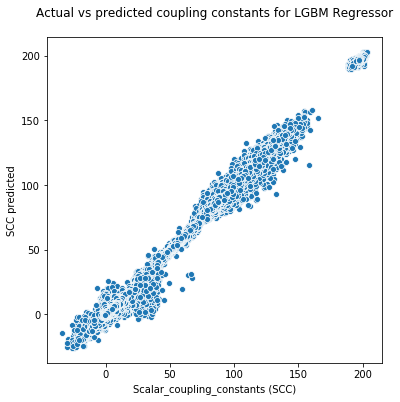

In [0]:
# plot predicted vs actual for whole validation set
import matplotlib.pyplot as plt
plot_data_lgbreg = pd.DataFrame(data=preds_acc[:,1], columns=['scalar_coupling_constants'])
plot_data_lgbreg.index.name = 'id'
plot_data_lgbreg['preds'] = preds_acc[:,2]

plot_preds(plot_data_lgbreg, "LGBM Regressor")

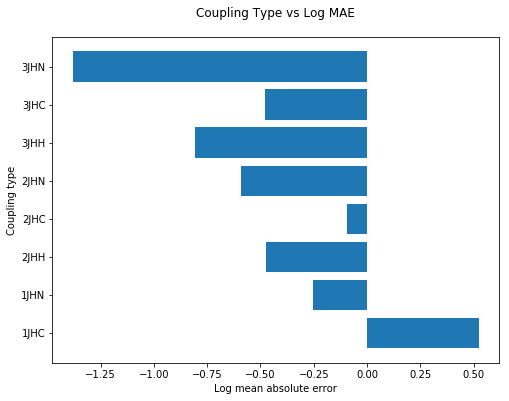

In [0]:
# Plot log MAE score by coupling type
from matplotlib.ticker import FormatStrFormatter
vals = [i[1] for i in preds_type_mae]
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(types, vals)
plt.xlabel('Log mean absolute error')
plt.ylabel('Coupling type')
plt.title('Coupling Type vs Log MAE', pad=20)
plt.show()


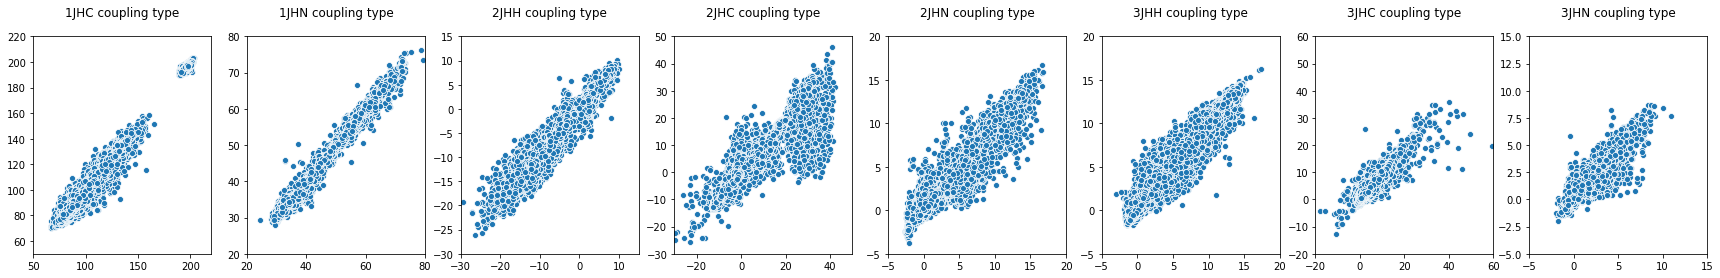

In [0]:
# plot predicted vs actual for each type of j coupling, 1j, 2j and 3j
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30,4))
low = [50, 20, -30, -30, -5, -5, -20, -5]
high = [220, 80, 15, 50, 20, 20, 60, 15]
def plot_preds_by_type(data, i, t):
    plt.subplot(1,8,i+1)
    sns.scatterplot(x=np.array(data)[:,1], y=np.array(data)[:,2])
    plt.title(f'{t} coupling type', pad='20')
    plt.xlim(low[i], high[i])
    plt.ylim(low[i], high[i])

for i, t in enumerate(types): 
    plot_preds_by_type(preds_type[i], i, t)
    
fig.show()

## Sample submission 

Final predictions on the test set were made using LGBMRegressor model trained on the subsetted dataset with hyperparameter tuning by GridSeach and increasing n_iterations to 4000 (not shown for brevity). This gave a best validation log MAE of 0.38.

Predictions on the test set using this model and submission to Kaggle recorded a MAE of -0.44 which placed 1697/2740 on private leaderboard.

In [0]:
# make predictions on test set (remember X_test = test[cols].values)
predictions = model_lgbreg.predict(X_test)

In [0]:
# prepare submission file
sample_submission = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')

sub = sample_submission.copy()
sub['scalar_coupling_constant'] = predictions
sub.to_csv('LGBM_submission.csv', index=False)

In [0]:
sub.head()

,id,scalar_coupling_constant
0,4658147,15.282586
1,4658148,203.466888
2,4658149,-0.412847
3,4658150,202.394570
4,4658151,14.907041


## Next Steps
1. From our reading about coupling constants we know that their magnitude (the prediction target) is mainly determined by atom hybridizations, bond lengths and coupling angles (cosine and dihedral). However, it is also known that the coupling constant can be calculated from the 3D geometry of the molecule (the current standard). Thus, it follows that adding further features describing atomic geometry might improve prediction. One approach is to calculate a larger set of distance vectors between neighboring atoms to give a fuller picture of the molecular geometry surrrounding coupled atoms.  

2. This approach will generate a lot more data for each coupling pair so we can move to a deep learning model which might be able to learn more nuanced patterns in the training set and improve accuracy on the test set. 

We take both of these approaches and implement them in the next and final notebook in this short series https://www.kaggle.com/mathewhall/champs-molecular-properties-nn-models
